In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


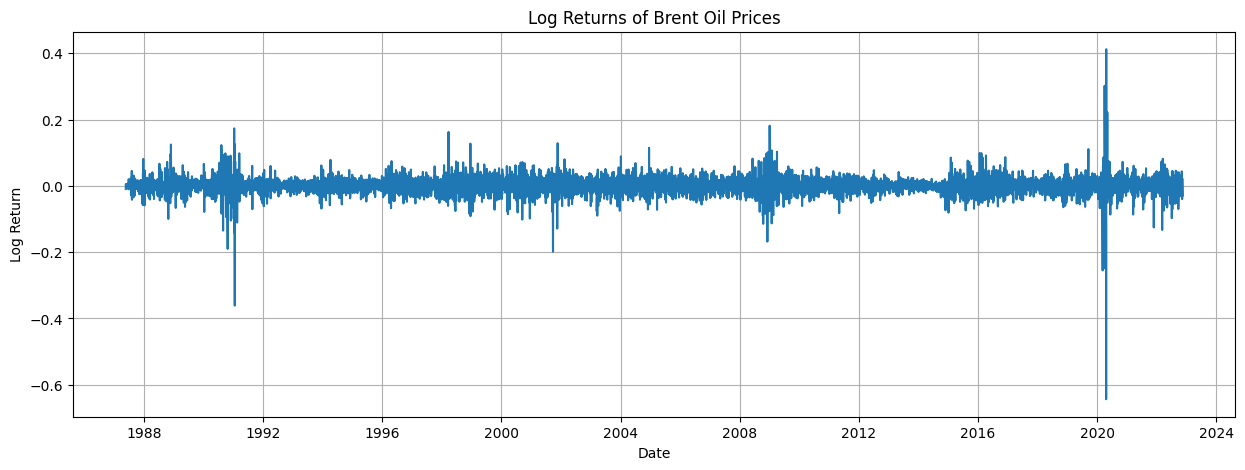

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [2]:
import sys
import os
import importlib.util

# Define the base path for your Google Drive
drive_base_path = '/content/drive/MyDrive'
scripts_path = os.path.join(drive_base_path, 'scripts')

# Ensure the scripts directory is in sys.path for relative imports within scripts (if any)
# Although we are using importlib for the initial load, adding to sys.path doesn't hurt.
if drive_base_path not in sys.path:
    sys.path.append(drive_base_path)

# Function to load a module from a specific file path
def load_module_from_path(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

# Load load_data and preprocess modules using importlib
try:
    load_data_module = load_module_from_path("scripts.load_data", os.path.join(scripts_path, "load_data.py"))
    preprocess_module = load_module_from_path("scripts.preprocess", os.path.join(scripts_path, "preprocess.py"))
except FileNotFoundError as e:
    print(f"Error loading script file: {e}")
    # Exit or handle the error appropriately
    exit() # Or set a flag to skip further execution

import matplotlib.pyplot as plt

# Access functions from the loaded modules
load_brent_data = load_data_module.load_brent_data
# clean_prices = preprocess_module.clean_prices # Clean prices is not used in the original code
compute_log_returns = preprocess_module.compute_log_returns


# Load and preprocess
# Assuming your data file is located at /content/drive/MyDrive/data/BrentOilPrices.csv
data_filepath = "/content/drive/MyDrive/data/BrentOilPrices.csv" # Use direct path string
df = load_brent_data(data_filepath)

# Add a check to ensure df was loaded successfully before proceeding
if df is not None:
    df = compute_log_returns(df)

    # Plot log returns
    plt.figure(figsize=(15, 5))
    plt.plot(df["Date"], df["Log_Return"])
    plt.title("Log Returns of Brent Oil Prices")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.grid(True)
    plt.show()

    import pymc as pm
    import pytensor.tensor as pt
    import numpy as np

    # Data
    log_returns = df["Log_Return"].values
    n = len(log_returns)
    idx = np.arange(n)

    with pm.Model() as multi_change_point_model:
        # Number of change points (e.g., 3 additional breaks, making 4 segments)
        n_changes = 3

        # Reparameterization: Define raw, unordered continuous change points on the interval [0, n-1]
        tau_raw_continuous = pm.Uniform("tau_raw_continuous", lower=0, upper=n-1, shape=n_changes)

        # Ensure change points are ordered using pt.sort
        # These are still continuous
        taus_continuous = pm.Deterministic("taus_continuous", pt.sort(tau_raw_continuous))

        # Parameters for each segment (n_changes + 1 segments)
        mus = [pm.Normal(f"mu_{i}", mu=0, sigma=1) for i in range(n_changes + 1)]
        sigmas = [pm.HalfNormal(f"sigma_{i}", sigma=1) for i in range(n_changes + 1)]

        # Use pt.searchsorted to determine which segment each data point belongs to
        # searchsorted returns the index where each element of idx would be inserted into taus_continuous
        # This effectively gives us the segment index for each data point
        segment_indices = pt.searchsorted(taus_continuous, idx)

        # Use pt.take to select the appropriate mu and sigma for each data point based on segment_indices
        mu = pt.take(pt.stack(mus), segment_indices)
        sigma = pt.take(pt.stack(sigmas), segment_indices)


        # Likelihood
        obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=log_returns)

        # Sampling
        # Increased target_accept significantly to try and reduce divergences
        trace = pm.sample(500, tune=500, chains=4, cores=1, target_accept=0.999, return_inferencedata=True)

else:
    print("Data loading failed. Cannot proceed with analysis.")

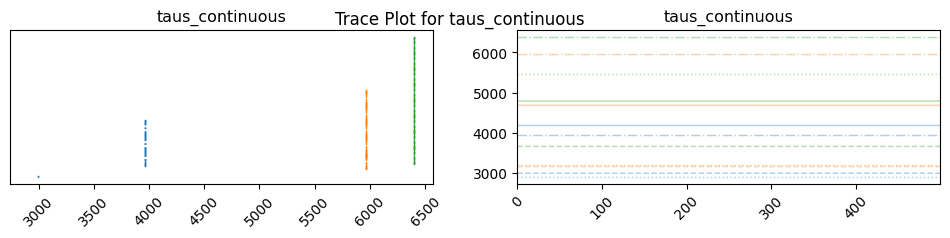

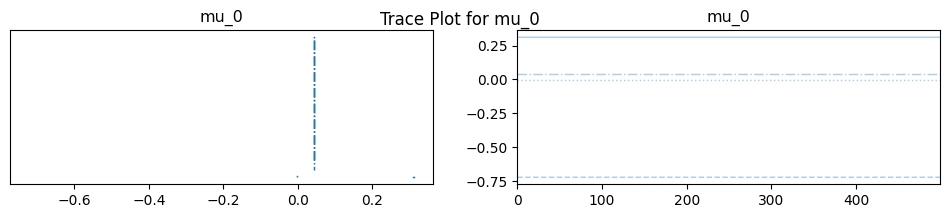

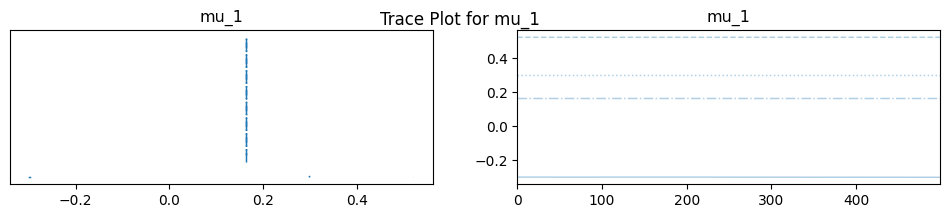

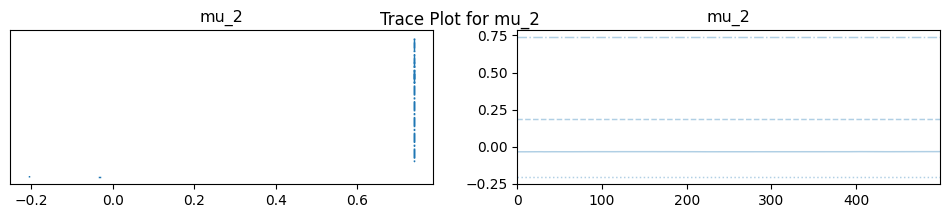

In [4]:
import arviz as az
import matplotlib.pyplot as plt

# Check summary
# Use the correct variable names from the PyMC model trace
az.summary(trace, var_names=["taus_continuous", "mu_0", "mu_1", "mu_2", "sigma_0", "sigma_1", "sigma_2"])

# Plot trace for each variable individually
trace_vars = ["taus_continuous", "mu_0", "mu_1", "mu_2"]
for var_name in trace_vars:
    axes = az.plot_trace(trace, var_names=[var_name])
    plt.suptitle(f"Trace Plot for {var_name}") # Add a title to each plot

    # Rotate x-axis labels for 'taus' plot if they are overlapping
    if var_name == "taus_continuous":
        for ax in axes.flatten():
            ax.tick_params(axis='x', rotation=45) # Rotate labels by 45 degrees

    plt.show() # Display each plot

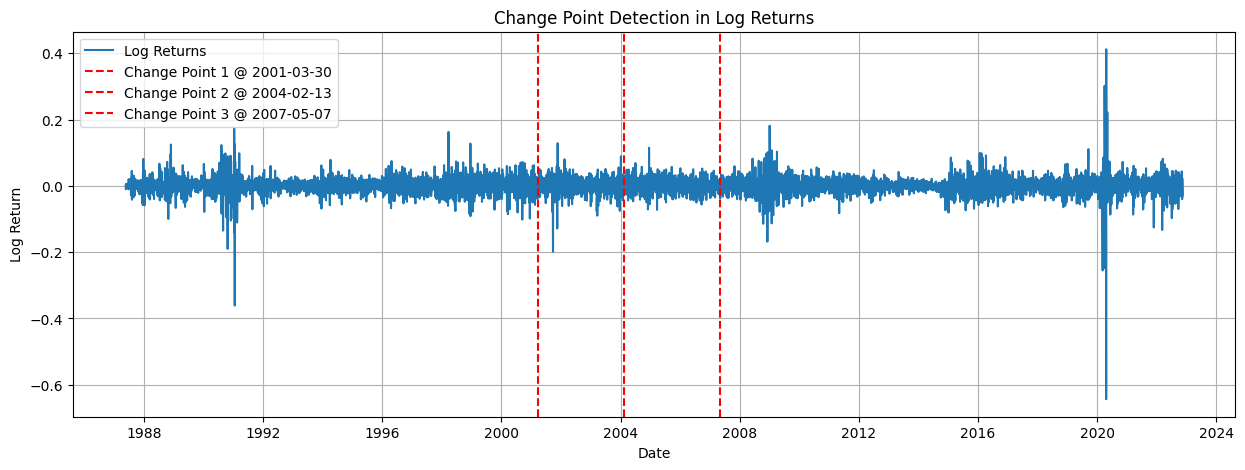

In [6]:
# Extract posterior estimates for taus
# taus is a 2-element array for the two change points
taus_posterior = trace.posterior["taus_continuous"].values

# Calculate the mean posterior estimate for each change point
# The shape of taus_posterior is (chain, draw, n_changes)
# We want to average over chains and draws to get a mean for each change point
tau_estimates = np.mean(taus_posterior, axis=(0, 1))

# Visualize the change points on log returns
plt.figure(figsize=(15, 5))
plt.plot(df["Date"], df["Log_Return"], label="Log Returns")

# Add vertical lines for each estimated change point
for i, tau_estimate in enumerate(tau_estimates):
    # Ensure the index is an integer
    tau_index = int(np.round(tau_estimate))
    # Get the corresponding date
    change_point_date = df["Date"].iloc[tau_index].date()
    plt.axvline(df["Date"].iloc[tau_index], color="red", linestyle="--", label=f"Change Point {i+1} @ {change_point_date}")

plt.title("Change Point Detection in Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Extract posterior samples for mu_0 and mu_1
mu0_vals = trace.posterior["mu_0"].values.flatten()
mu1_vals = trace.posterior["mu_1"].values.flatten()
mu2_vals = trace.posterior["mu_2"].values.flatten()

# Calculate the probability that mu_1 > mu_0
prob = np.mean(mu1_vals > mu0_vals)
print(f"Probability that mu_1 > mu_0: {prob:.2%}")
print(f"Probability that mu_2 > mu_0: {np.mean(mu2_vals > mu0_vals):.2%}")


Probability that mu_1 > mu_0: 75.00%
Probability that mu_2 > mu_0: 50.00%
